In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import numpy as np
import xgboost as xgb
from sklearn.cluster import KMeans
from scipy.stats import iqr
from matplotlib.ticker import FuncFormatter
from sklearn.preprocessing import LabelEncoder, RobustScaler
from sklearn.metrics import confusion_matrix, classification_report, make_scorer, f1_score, roc_auc_score, precision_score, recall_score, matthews_corrcoef, roc_curve, auc
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import RandomForestClassifier
sns.set(style="whitegrid")

<h1>Fraud Detection</h1>


Copyright (c) 2023 Radostin Dimkov

This work is licensed under a [Creative Commons Attribution-NonCommercial 4.0 International License](https://creativecommons.org/licenses/by-nc/4.0/legalcode).

Dataset is not included. It can be downloaded from here - https://www.kaggle.com/datasets/rupakroy/online-payments-fraud-detection-dataset

In [2]:
df = pd.read_csv('PS_20174392719_1491204439457_log.csv')

In [ ]:
df.info();

<h3>Data Description</h3>

The dataset contains information about online transactions and their characteristics. Each transaction is represented by a row in the dataset, with the following attributes:

<h4> Fields </h4>

1. **step:**
   - *Definition:* Represents a unit of time in the real world, where each step corresponds to one hour.
   - *Context:* The simulation spans 30 days, and there are a total of 744 steps.

2. **type:**
   - *Definition:* Denotes the type of transaction and can take values such as CASH-IN, CASH-OUT, DEBIT, PAYMENT, and TRANSFER.
   - *Context:* Describes the nature of the financial activity undertaken in each transaction.

3. **amount:**
   - *Definition:* Signifies the monetary value of the transaction.
   - *Context:* Represents the amount of funds involved in each financial operation.

4. **nameOrg:**
   - *Definition:* Identifies the customer initiating the transaction.
   - *Context:* Associates each transaction with the account holder responsible for its initiation.

5. **oldbalanceOrg:**
   - *Definition:* Reflects the initial account balance of the customer before the transaction.
   - *Context:* Provides the starting financial position of the account holder.

6. **newbalanceOrg:**
   - *Definition:* Indicates the new account balance of the customer after the transaction.
   - *Context:* Captures the updated financial status of the account holder following the transaction.

7. **nameDest:**
   - *Definition:* Identifies the recipient customer of the transaction.
   - *Context:* Associates transactions with the account to which funds are being transferred.

8. **oldbalanceDest:**
   - *Definition:* Represents the initial account balance of the recipient before the transaction. There is not information for customers that start with M (Merchants).
   - *Context:* Offers insight into the starting financial position of the recipient account. 

9. **newbalanceDest:**
   - *Definition:* Signifies the new account balance of the recipient after the transaction. There is not information for customers that start with M (Merchants).
   - *Context:* Captures the updated financial status of the recipient account following the transaction.

10. **isFraud:**
    - *Definition:* Binary indicator (0 or 1) highlighting whether the transaction is fraudulent (1) or not (0).
    - *Context:* Identifies transactions involving fraudulent behavior within the simulation.
    
   

<h4>Goal</h4>

The primary objective of this analysis is to develop a robust classification model that can accurately predict whether a given online transaction is fraudulent or not. Leveraging the features provided in the dataset, the goal is to train a machine learning model capable of distinguishing between legitimate and fraudulent transactions.

<h4> Approach: </h4>

- **Exploratory Data Analysis (EDA):**

   - Exploratory Data Analysis (EDA) is a crucial step in the data analysis process. It involves the use of statistical and graphical techniques to explore the characteristics of a dataset, understand its underlying structure, and uncover patterns, trends, relationships, and potential outliers. EDA is typically performed at the early stages of a data science or machine learning project to gain insights and inform subsequent steps in the analysis.


- **Data Preprocessing:**
   - Address any missing or anomalous values in the dataset. Encode categorical variables, if necessary. Scale numerical features to ensure uniformity in their impact on the model.


- **Handling Imbalance:**
  - Implement techniques to address class imbalance, such as oversampling the minority class (fraudulent transactions) using methods like SMOTE or undersampling the majority class.


- **Model Selection:**
   - Experiment with different classification algorithms such as Logistic Regression, Random Forest, XGBoost, etc.
        Utilize appropriate evaluation metrics for imbalanced datasets, emphasizing metrics like precision, recall, F1-score, and ROC-AUC.


- **Hyperparameter Tuning:**
   - Conduct a systematic search for optimal hyperparameters using techniques like GridSearchCV or RandomizedSearchCV to improve model performance.


- **Model Evaluation:**
   - Evaluate the performance of the trained model on a separate test dataset.
        Assess the model's ability to correctly classify fraudulent transactions while minimizing false positives.

- **Interpretability and Explainability:**
   - Strive for a model that not only performs well but is also interpretable.
        Understand the importance of each feature in the decision-making process.

In [4]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [5]:
df.tail()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
6362615,743,CASH_OUT,339682.13,C786484425,339682.13,0.0,C776919290,0.00,339682.13,1,0
6362616,743,TRANSFER,6311409.28,C1529008245,6311409.28,0.0,C1881841831,0.00,0.00,1,0
6362617,743,CASH_OUT,6311409.28,C1162922333,6311409.28,0.0,C1365125890,68488.84,6379898.11,1,0
6362618,743,TRANSFER,850002.52,C1685995037,850002.52,0.0,C2080388513,0.00,0.00,1,0
6362619,743,CASH_OUT,850002.52,C1280323807,850002.52,0.0,C873221189,6510099.11,7360101.63,1,0


Inconsistencies were identified in certain column names, specifically <i>'newbalanceOrig'</i> and <i>'nameOrig'</i>. To ensure clarity and a standardized representation, these columns were renamed to <i>'newbalanceOrg'</i> and <i>'nameOrg'</i>, respectively. This strategic renaming aligns with a uniform naming convention, fostering a more intuitive understanding of the dataset. The modification aims to enhance data integrity, maintain consistency, and contribute to a more cohesive and comprehensible representation of the information within the columns, thereby facilitating a smoother analytical process.

In [6]:
df = df.rename(columns={'newbalanceOrig': 'newbalanceOrg', 'nameOrig': 'nameOrg'})

In [7]:
df.isna().sum()

step              0
type              0
amount            0
nameOrg           0
oldbalanceOrg     0
newbalanceOrg     0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

There are no missing values in the dataset. Each column has a count of zero when assessed for the presence of null or missing values, indicating that the dataset is complete and does not require imputation for any of its attributes. This absence of missing values is crucial for ensuring the reliability and completeness of the dataset during subsequent analyses.

In [8]:
df.duplicated().sum()

0

The dataset exhibits no duplicated values. The count of duplicated rows, as assessed using the duplicated() function, is zero. This absence of duplicates is significant in maintaining the integrity and reliability of the dataset, ensuring that each transaction record is unique and preventing any potential distortions in the analysis due to redundant information.

In [9]:
num_rows, num_columns = df.shape
print(f"Number of rows: {num_rows:,}")
print("Number of columns:", num_columns)

Number of rows: 6,362,620
Number of columns: 11


<h3> Explore the data </h3>

In [10]:
#Define custom colors
light_orange = '#ffd699'
light_red = '#ff9999'

Two custom colors have been defined for visualizing fraud transactions:

- light_orange: A warm, attention-grabbing color.
- light_red: A subtle red shade for highlighting critical elements.

These colors will be utilized in plots to enhance the visibility of fraud-related information, ensuring that the representation is both informative and visually engaging during data analysis.

In [11]:
unique_types = df['type'].unique();
type_counts = df['type'].value_counts()

num_unique_types = len(unique_types)
print(type_counts)

CASH_OUT    2237500
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     532909
DEBIT         41432
Name: type, dtype: int64


There are five distinct types of transactions in the dataset: PAYMENT, TRANSFER, CASH_OUT, DEBIT, and CASH_IN.

The distribution of these transaction types is as follows:

   - CASH_OUT: 2,237,500 transactions
   - PAYMENT: 2,151,495 transactions
   - CASH_IN: 1,399,284 transactions
   - TRANSFER: 532,909 transactions
   - DEBIT: 41,432 transactions

This information provides an overview of the variety and prevalence of transaction types within the dataset.

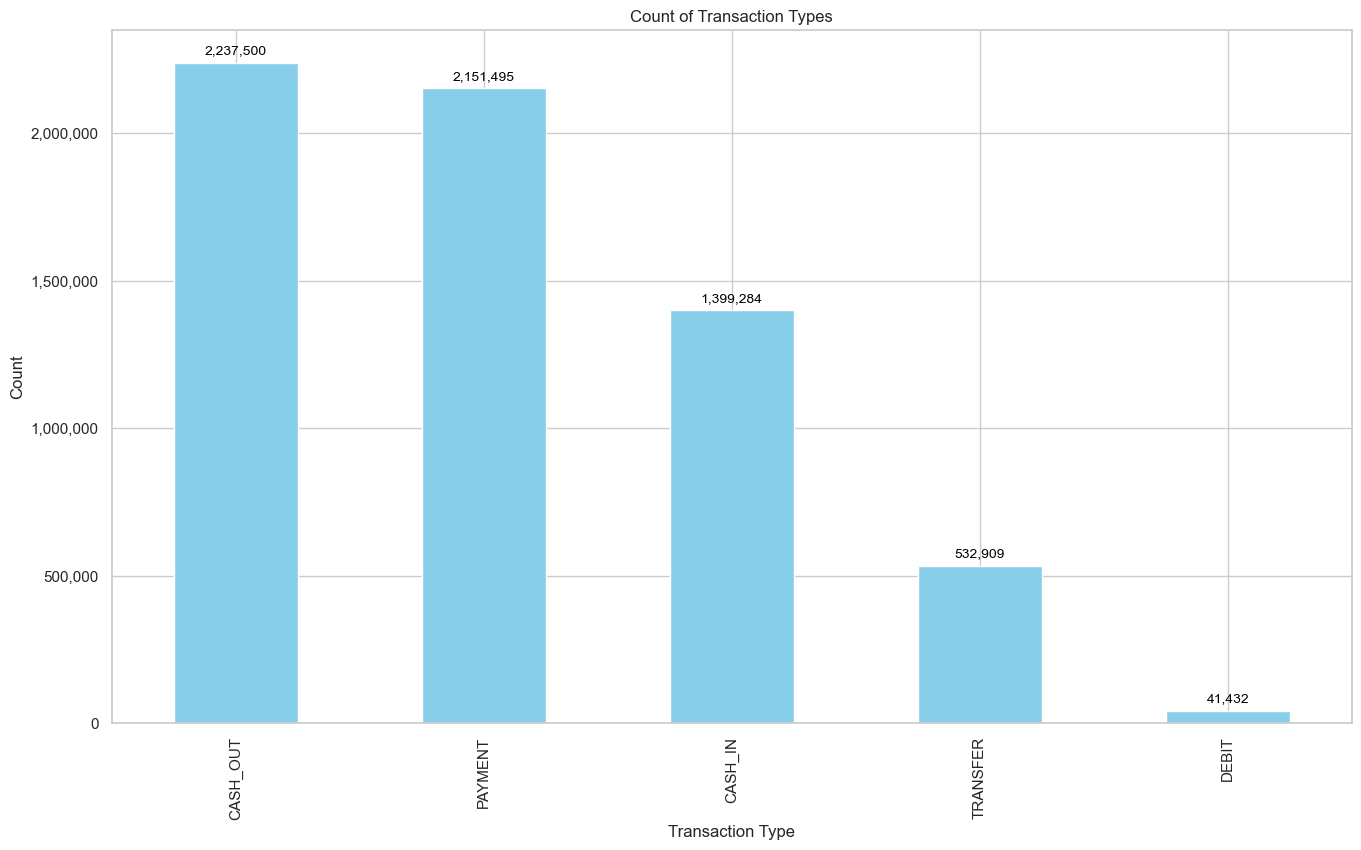

In [12]:
plt.figure(figsize=(16, 9))
plt.title('Count of Transaction Types')
plt.xlabel('Transaction Type')
plt.ylabel('Count')
bars = type_counts.plot(kind='bar', color='skyblue')

# Add data labels on top of each bar
for bar in bars.patches:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 20000, f'{yval:,.0f}', ha='center', va='bottom', fontsize=10, color='black')

# Format count axis ticks
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda value, _: f'{value:,.0f}'))
plt.show()

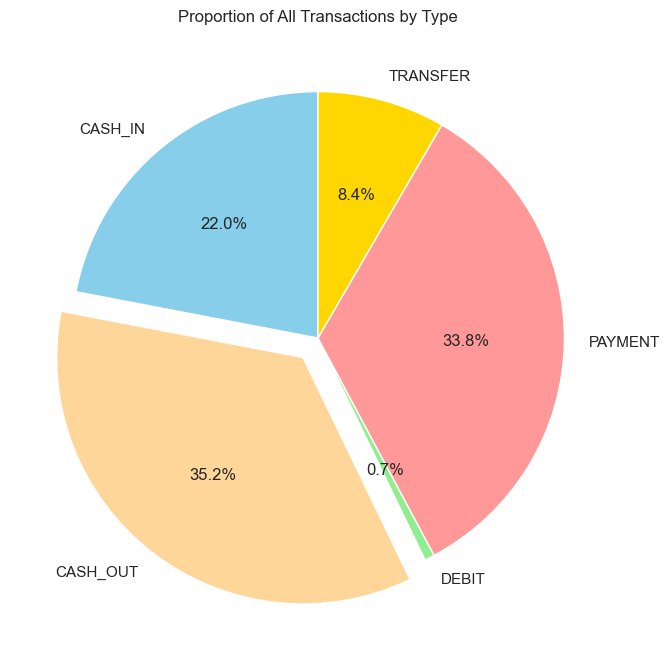

In [13]:
all_counts_by_type = df.groupby("type").size()
plt.figure(figsize=(8, 8))
plt.pie(all_counts_by_type, labels=all_counts_by_type.index, autopct='%1.1f%%', startangle=90, colors=['skyblue', light_orange, 'lightgreen', light_red, 'gold'], explode=(0, 0.1, 0, 0, 0))
plt.title('Proportion of All Transactions by Type')
plt.show()

The chart illustrates the proportion of each transaction type relative to the total number of transactions

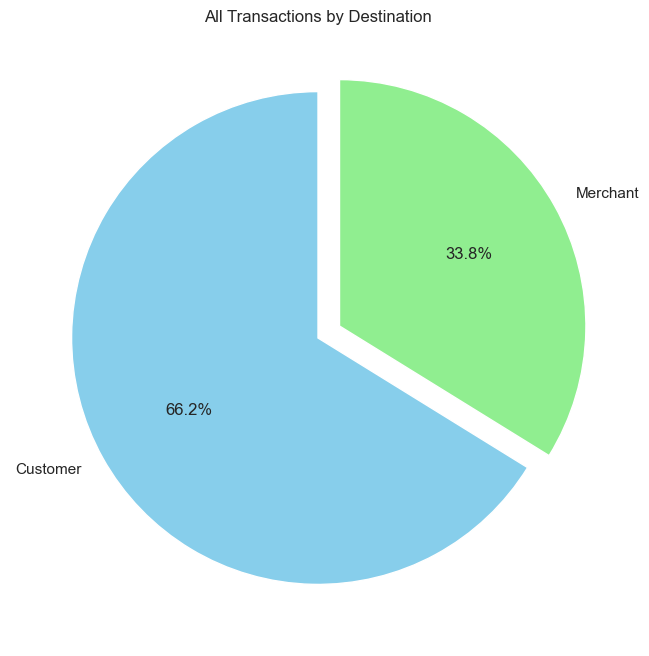

In [14]:
df_copy = df.copy();
df_copy['nameDest_first_letter'] = df_copy['nameDest'].str[0]
df_copy['nameDest_first_letter'] = df_copy['nameDest_first_letter'].replace('C', 'Customer')
df_copy['nameDest_first_letter'] = df_copy['nameDest_first_letter'].replace('M', 'Merchant')
all_by_dest = df_copy.groupby('nameDest_first_letter').size()

plt.figure(figsize=(8, 8))
plt.pie(all_by_dest, labels=all_by_dest.index, autopct='%1.1f%%', startangle=90, colors=['skyblue', 'lightgreen'], explode=(0, 0.1))
plt.title('All Transactions by Destination')
plt.show()

The chart illustrates the proportion of all transactionsrelative to the destination

In [15]:
fraud_count = df[df["isFraud"] == 1].shape[0]
non_fraud_count = df[df["isFraud"] == 0].shape[0]

print(f"Count of Fraud Transactions: {f'{fraud_count:,.0f}'}")
print(f"Count of Non-fraud Transactions: {f'{non_fraud_count:,.0f}'}")

Count of Fraud Transactions: 8,213
Count of Non-fraud Transactions: 6,354,407


This highly imbalanced distribution, where the number of non-fraudulent transactions substantially outweighs the number of fraudulent transactions, can pose challenges during model training. It is crucial to address this class imbalance to ensure that the machine learning model does not become biased towards the majority class, leading to suboptimal performance in identifying the minority class (fraudulent transactions)

In [16]:
total_transactions = fraud_count + non_fraud_count

fraud_percentage = (fraud_count / total_transactions) * 100
non_fraud_percentage = (non_fraud_count / total_transactions) * 100

print(f"Fraud Transactions percentage: {fraud_percentage:.2f}%")
print(f"Non-fraud Transactions percentage: {non_fraud_percentage:.2f}%")

Fraud Transactions percentage: 0.13%
Non-fraud Transactions percentage: 99.87%


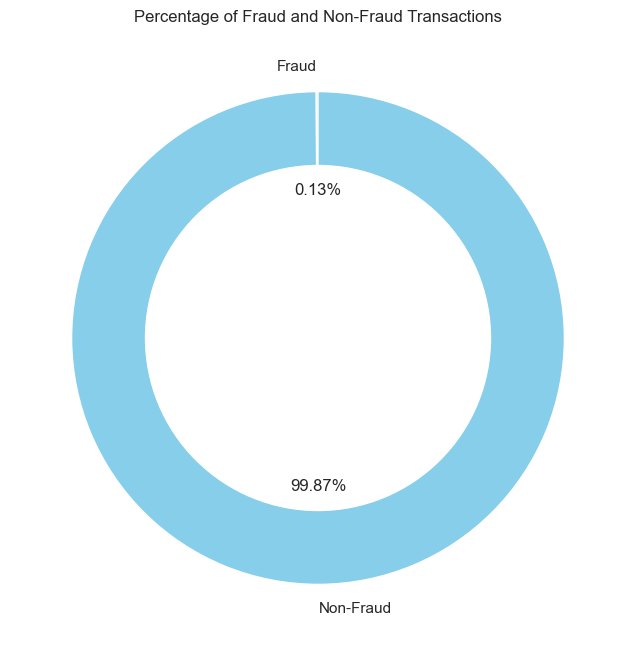

In [17]:
labels = ['Fraud', 'Non-Fraud']
sizes = [fraud_percentage, non_fraud_percentage]
colors = ['orange', 'skyblue']

fig, ax = plt.subplots(figsize=(8, 8))
ax.pie(sizes, labels=labels, autopct='%1.2f%%', startangle=90, colors=colors)
centre_circle = plt.Circle((0, 0), 0.70, fc='white')
fig.gca().add_artist(centre_circle)

plt.title('Percentage of Fraud and Non-Fraud Transactions')
plt.show()

With 99.87% of the transactions being classified as genuine (6,354,407), and only 0.13% (8,213) identified as fraudulent, a simplistic approach of blindly predicting all transactions as genuine would yield an accuracy of 99.8%. This high accuracy, driven by the dominance of genuine transactions, underscores the challenge posed by the class imbalance in the dataset. 

type
CASH_OUT    4116
TRANSFER    4097
dtype: int64


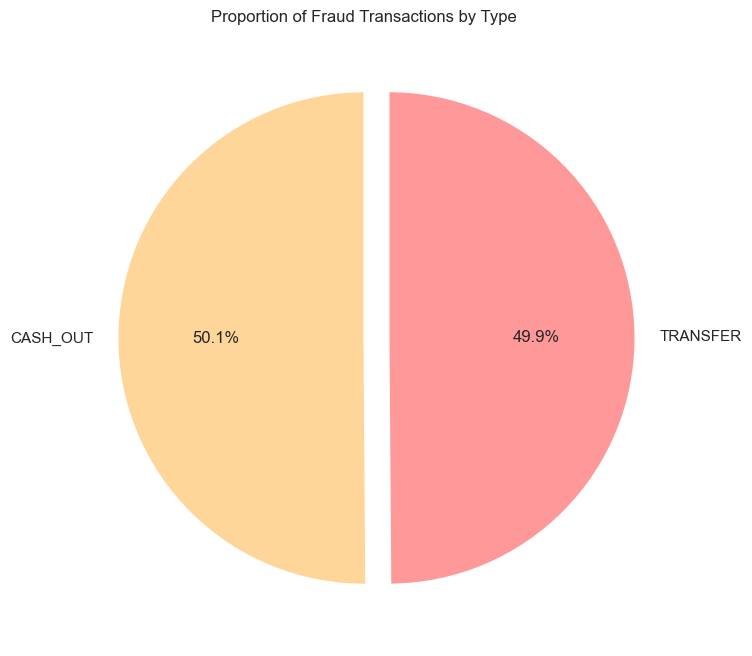

In [18]:
fraud_transactions = df[df["isFraud"] == 1]
fraud_counts_by_type = fraud_transactions.groupby("type").size()
print(fraud_counts_by_type)

plt.figure(figsize=(8, 8))
plt.pie(fraud_counts_by_type, labels=fraud_counts_by_type.index, autopct='%1.1f%%', startangle=90, colors=[light_orange, light_red], explode=(0, 0.1))
plt.title('Proportion of Fraud Transactions by Type')
plt.show()

This concentration of fraud within CASH_OUT and TRANSFER transactions suggests that these specific types may be more susceptible to fraudulent activities

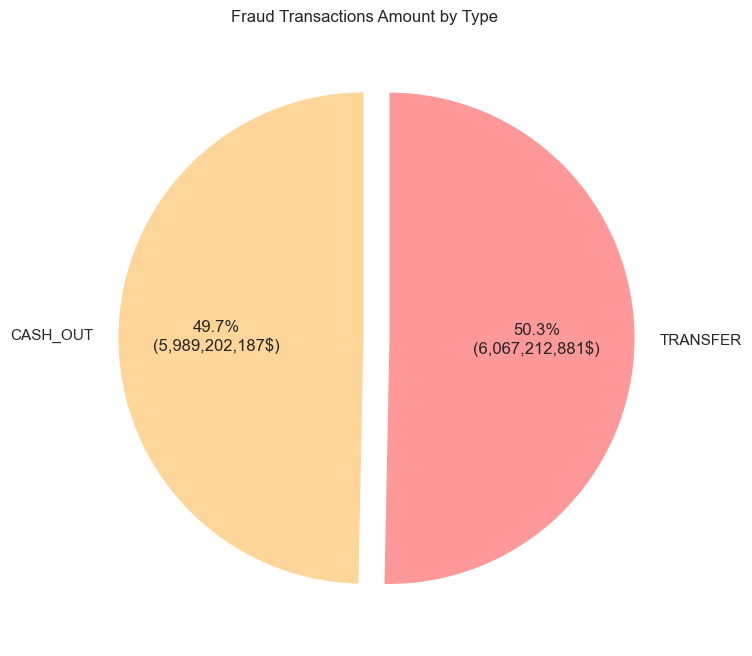

In [19]:
fraud_amounts_by_type = df[df["isFraud"] == 1].groupby("type")["amount"].sum()
plt.figure(figsize=(8, 8))
plt.pie(fraud_amounts_by_type, labels=fraud_amounts_by_type.index, autopct=lambda p: f'{p:.1f}%\n({p * sum(fraud_amounts_by_type) / 100:,.0f}$)', startangle=90, colors=[light_orange, light_red], explode=(0, 0.1))
plt.title('Fraud Transactions Amount by Type')
plt.show()

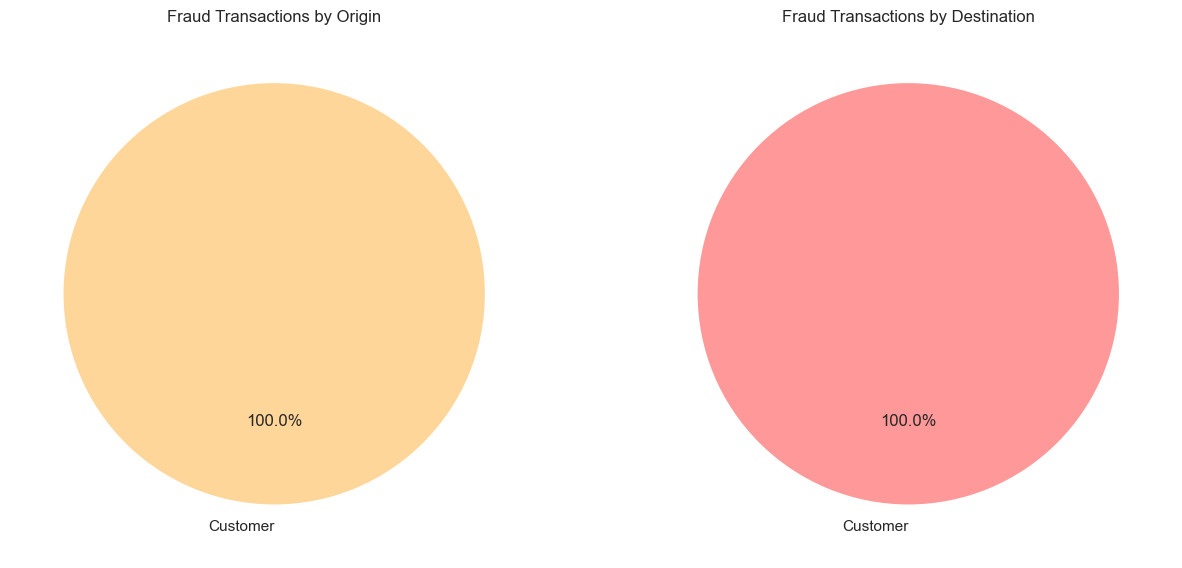

In [20]:
fraud_transactions = df[df['isFraud'] == 1].copy()
fraud_transactions['nameOrg_first_letter'] = fraud_transactions['nameOrg'].str[0]
fraud_transactions['nameDest_first_letter'] = fraud_transactions['nameDest'].str[0]
fraud_transactions['nameOrg_first_letter'] = fraud_transactions['nameOrg_first_letter'].replace('C', 'Customer')
fraud_transactions['nameDest_first_letter'] = fraud_transactions['nameDest_first_letter'].replace('C', 'Customer')
fraud_by_name_orig_first_letter = fraud_transactions.groupby('nameOrg_first_letter').size()
fraud_by_name_dest_first_letter = fraud_transactions.groupby('nameDest_first_letter').size()
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 8))

axes[0].pie(fraud_by_name_orig_first_letter, labels=fraud_by_name_orig_first_letter.index, autopct='%1.1f%%', startangle=90, colors=[light_orange])
axes[0].set_title('Fraud Transactions by Origin')

axes[1].pie(fraud_by_name_dest_first_letter, labels=fraud_by_name_dest_first_letter.index, autopct='%1.1f%%', startangle=90, colors=[light_red])
axes[1].set_title('Fraud Transactions by Destination')

plt.show()

The analysis of fraud transactions reveals a distinct pattern: all fraudulent transactions involve interactions between customers, both as the originators and recipients. This implies that fraudulent activities, as identified in the dataset, exclusively occur within transactions involving customers on both ends. Understanding such patterns is crucial for refining fraud detection strategies and implementing targeted measures to enhance security within customer-to-customer transactions.

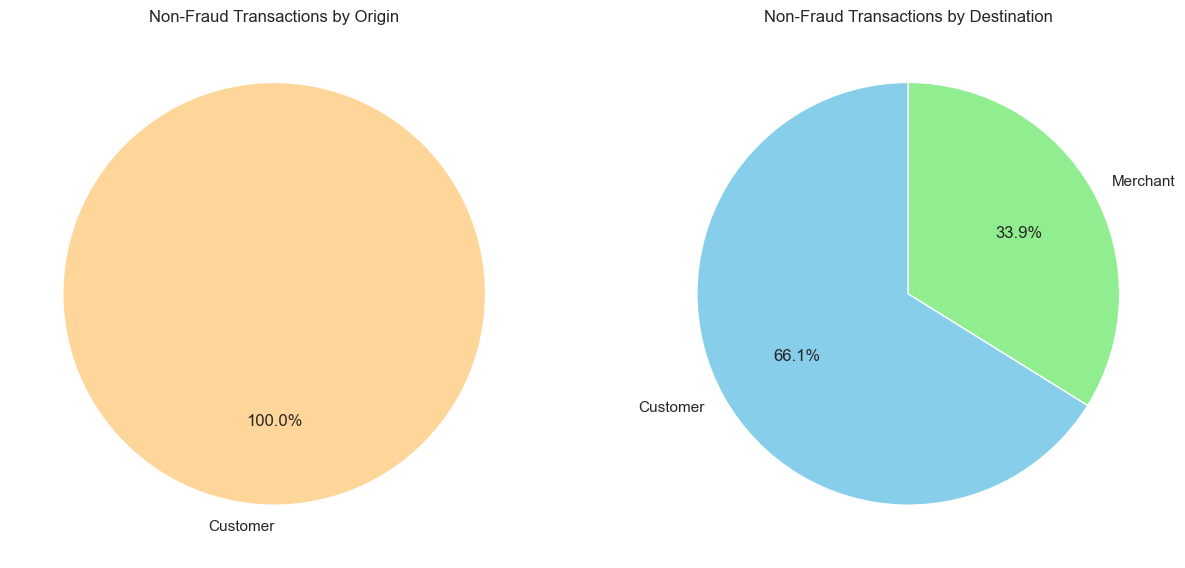

In [21]:
non_fraud_transactions = df[df['isFraud'] == 0].copy()
non_fraud_transactions['nameOrg_first_letter'] = non_fraud_transactions['nameOrg'].str[0]
non_fraud_transactions['nameDest_first_letter'] = non_fraud_transactions['nameDest'].str[0]
non_fraud_transactions['nameOrg_first_letter'] = non_fraud_transactions['nameOrg_first_letter'].replace({'C': 'Customer', 'M': 'Merchant'})
non_fraud_transactions['nameDest_first_letter'] = non_fraud_transactions['nameDest_first_letter'].replace({'C': 'Customer', 'M': 'Merchant'})

non_fraud_by_name_orig_first_letter = non_fraud_transactions.groupby('nameOrg_first_letter').size()
non_fraud_by_name_dest_first_letter = non_fraud_transactions.groupby('nameDest_first_letter').size()

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 8))

# Pie chart for Non-Fraud Transactions by Origin
axes[0].pie(non_fraud_by_name_orig_first_letter, labels=non_fraud_by_name_orig_first_letter.index, autopct='%1.1f%%', startangle=90, colors=[light_orange, 'lightcoral'])
axes[0].set_title('Non-Fraud Transactions by Origin')

# Pie chart for Non-Fraud Transactions by Destination
axes[1].pie(non_fraud_by_name_dest_first_letter, labels=non_fraud_by_name_dest_first_letter.index, autopct='%1.1f%%', startangle=90, colors=['skyblue', 'lightgreen'])
axes[1].set_title('Non-Fraud Transactions by Destination')

plt.show()

In [22]:
pd.set_option('display.float_format', '{:,.2f}'.format)
print("Statistics on the amounts for non-fraud transactions:\n", pd.DataFrame.describe(df[df["isFraud"] == 0].amount), "\n")
print("Statistics on the amounts for fraud transactions:\n", pd.DataFrame.describe(df[df["isFraud"] == 1].amount), "\n")

Statistics on the amounts for non-fraud transactions:
 count    6,354,407.00
mean       178,197.04
std        596,236.98
min              0.01
25%         13,368.40
50%         74,684.72
75%        208,364.76
max     92,445,516.64
Name: amount, dtype: float64 

Statistics on the amounts for fraud transactions:
 count        8,213.00
mean     1,467,967.30
std      2,404,252.95
min              0.00
25%        127,091.33
50%        441,423.44
75%      1,517,771.48
max     10,000,000.00
Name: amount, dtype: float64 



Key Observations:

   - Fraudulent transactions, on average, involve significantly higher amounts compared to non-fraudulent transactions.
   - The standard deviation for fraud transactions is notably higher, indicating a wider range of transaction amounts.
   - The minimum amount for fraud transactions is $0, suggesting instances of negligible or anomalous values in fraudulent activities.
   - The upper percentiles (75th and maximum) for fraud transactions demonstrate a substantial increase in the transaction amounts, further emphasizing the contrast between the two categories.

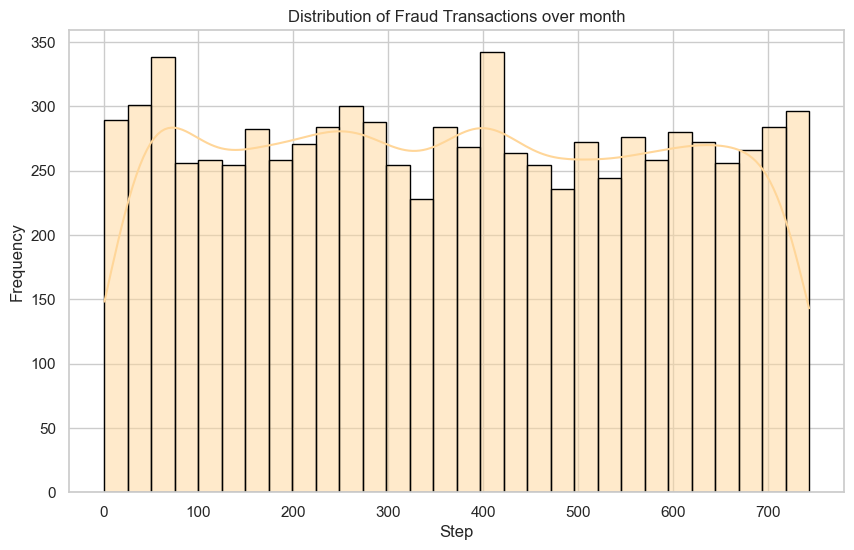

In [23]:
plt.figure(figsize=(10, 6))
sns.histplot(fraud_transactions["step"], bins=30, kde=True, color=light_orange, edgecolor='black')
plt.title('Distribution of Fraud Transactions over month')
plt.xlabel('Step')
plt.ylabel('Frequency')
plt.show()

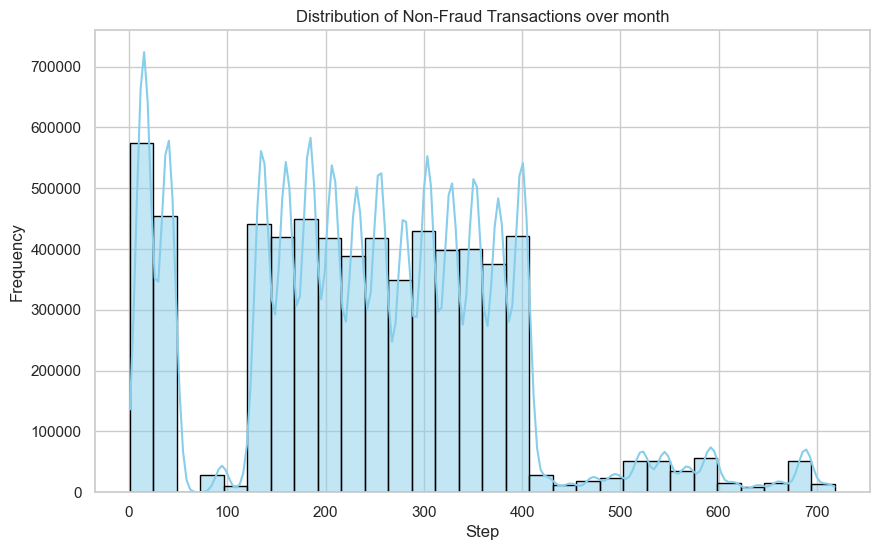

In [24]:
non_fraud_transactions = df[df["isFraud"] == 0]
plt.figure(figsize=(10, 6))
sns.histplot(non_fraud_transactions["step"], bins=30, kde=True, color='skyblue', edgecolor='black')
plt.title('Distribution of Non-Fraud Transactions over month')
plt.xlabel('Step')
plt.ylabel('Frequency')
plt.show()

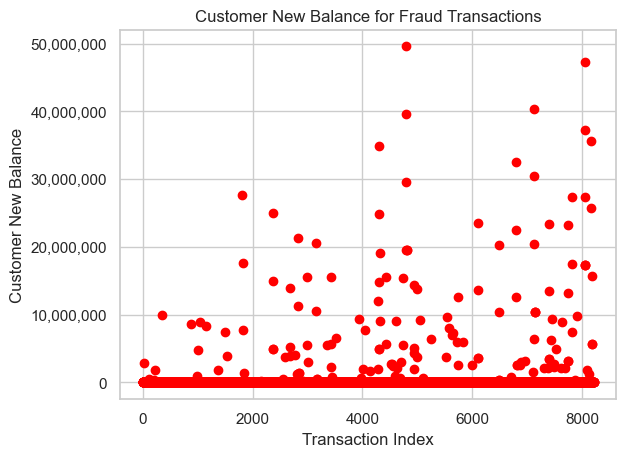

In [25]:
plt.scatter(range(len(fraud_transactions)), fraud_transactions['newbalanceOrg'], color='red')
plt.title('Customer New Balance for Fraud Transactions')
plt.xlabel('Transaction Index')
plt.ylabel('Customer New Balance')
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda value, _: f'{value:,.0f}'))

plt.show()


Many fraud transactions are linked to customers whose account balances drop to zero afterward. This pattern implies that fraudsters often manipulate transactions to deplete or minimize the affected customers' balances. Detecting and keeping an eye on instances where substantial transactions result in zero balances is crucial for preventing and identifying fraud. Understanding this pattern helps improve security measures and safeguards against fraudulent activities that aim to drain customer accounts.

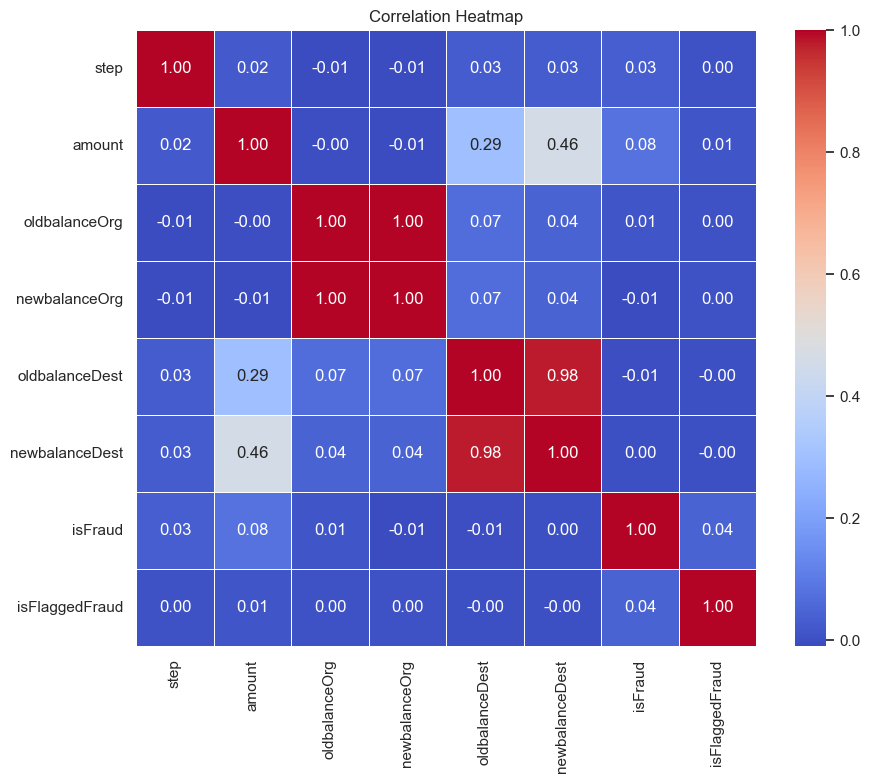

In [26]:
corr_matrix = df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

While the heatmap may not reveal strong correlations with the target variable (isFraud), it does highlight a noteworthy observation. There is a significant correlation between the new and old balances of accounts.
Although the heatmap may not directly assist in understanding fraud patterns, recognizing the correlation between certain features, such as old and new balances, can be valuable for refining feature engineering and developing more nuanced models for fraud detection.

<h3> Data processing </h3>

In [27]:
process_df = df.copy()

To facilitate data processing and analysis without altering the integrity of the original dataset, a copy of the DataFrame has been created and labeled as <i>process_df</i>. This duplicated DataFrame, <i>process_df</i>, serves as a working version, allowing for experimentation and modifications without impacting the original dataset denoted by the variable df. Utilizing a copy ensures a safeguard against unintended changes to the core dataset, providing a structured and controlled environment for further exploration and analysis.


In [28]:
process_df.drop('isFlaggedFraud', axis=1, inplace=True)

The column <i>'isFlaggedFraud'</i> has been dropped from the <i>process_df</i> DataFrame. This decision was made based on the assessment that the column does not serve a meaningful purpose in the context of the current analysis and is not relevant to our specific use case. By removing it, we streamline the dataset to focus on features that are more pertinent to the objectives of our analysis, contributing to a more concise and purpose-driven dataset.

In [29]:
types_to_exclude = ['CASH_IN', 'DEBIT', 'PAYMENT']
process_df = process_df[~process_df['type'].isin(types_to_exclude)]

To optimize the dataset and streamline it for analysis, transactions of types 'CASH_IN', 'DEBIT', and 'PAYMENT' have been excluded from the process_df DataFrame. This decision is grounded in the observation that there are no instances of fraud associated with these transaction types. By excluding these types, we aim to minimize the dataset proportions and focus on transaction categories that have relevance to the identification and analysis of fraudulent activities, thus enhancing the efficiency of subsequent modeling and analysis efforts.


In [30]:
print(f"Total count: {process_df.shape[0]}")

Total count: 2770409


We've substantially reduced the dataset, now containing 2,770,409 entries.

In [31]:
total_transactions = len(process_df)
wrong_org_balance = sum(process_df["oldbalanceOrg"] - process_df["amount"] != process_df["newbalanceOrg"])
wrong_dest_balance = sum(process_df["oldbalanceDest"] + process_df["amount"] != process_df["newbalanceDest"])
percentage_wrong_org_balance = (wrong_org_balance / total_transactions) * 100
percentage_wrong_dest_balance = (wrong_dest_balance / total_transactions) * 100

print(f"Percentage of wrong origin balances: {percentage_wrong_org_balance:.2f}%")
print(f"Percentage of wrong destination balances: {percentage_wrong_dest_balance:.2f}%")

Percentage of wrong origin balances: 93.72%
Percentage of wrong destination balances: 42.09%


A considerable number of balances in our dataset appear to be inaccurate. This suggests that a significant portion of transactions might have inconsistencies in their origin and destination balances.

In [32]:
process_df.loc[ (process_df["oldbalanceOrg"] == 0) | (process_df["oldbalanceOrg"] < process_df["amount"]), "oldbalanceOrg"] = process_df["amount"]
process_df["newbalanceOrg"] = process_df["oldbalanceOrg"] - process_df["amount"]
process_df["newbalanceDest"] = process_df["oldbalanceDest"] + process_df["amount"]

To rectify inconsistencies in the origin and destination balances, we've implemented a dynamic calculation approach. Here's a concise summary:

   - For transactions where the old origin balance is zero or less than the transaction amount, we set the old origin balance to be equal to the transaction amount.

   - The new origin balance is then computed as the difference between the old origin balance and the transaction amount.

   - The new destination balance is calculated by adding the transaction amount to the old destination balance.

This dynamic recalculation on-the-fly ensures that the balance information in the dataset is more accurate, addressing discrepancies and creating a reliable foundation for subsequent analyses and modeling.

In [33]:
process_df['isCustomerToCustomer'] = ((process_df['nameOrg'].str.startswith('C').astype(int) == 1) & (process_df['nameDest'].str.startswith('C').astype(int) == 1)).astype(int)

A new binary column, <i>'isCustomerToCustomer'</i> has been introduced in the <i>process_df</i> DataFrame. This column is determined based on whether both the <i>'nameOrg'</i> and <i>'nameDest'</i> columns start with the letter 'C,' signifying customers. The values in this column are 1 for transactions between customers and 0 otherwise. This addition aims to highlight transactions specifically involving customers on both the sending and receiving ends.

In [34]:
# Count rows where isCustomerToCustomer is 1 for each category of isFraud
count_by_fraud_customer_to_customer = process_df[process_df['isCustomerToCustomer'] == 1].groupby('isFraud').size()

print("Count of rows with isCustomerToCustomer = 1 by isFraud category:")
print(count_by_fraud_customer_to_customer)
print(f"Total count: {count_by_fraud_customer_to_customer.sum()}")

Count of rows with isCustomerToCustomer = 1 by isFraud category:
isFraud
0    2762196
1       8213
dtype: int64
Total count: 2770409


After filtering out specific transaction types, all the remaining transactions are now categorized as <i>'Customer to Customer'</i> in the dataset. The counts by the <i>'isFraud'</i> category confirm that every transaction falls into this category. As a result, we've decided to keep the <i>'isCustomerToCustomer'</i> column in the dataset since it distinguishes the nature of all transactions. This information might be useful for further analysis and could contribute to the identification of fraudulent activities.

In [35]:
process_df.drop(columns=['nameDest', 'nameOrg'], axis=1, inplace=True)

The columns <i>'nameDest'</i> and <i>'nameOrg'</i> have been removed from the process_df DataFrame as they were deemed unnecessary for the current analysis. This step is taken to streamline the dataset and focus on more relevant features, enhancing efficiency in subsequent analysis and modeling efforts.

In [36]:
label_encoder = LabelEncoder()
process_df['type'] = label_encoder.fit_transform(process_df['type'])

This transformation assigns numerical labels to the different transaction types, converting categorical data into a format suitable for machine learning models. The LabelEncoder helps in numerical representation of the 'type' column, facilitating its incorporation into algorithms for subsequent analysis and model training.

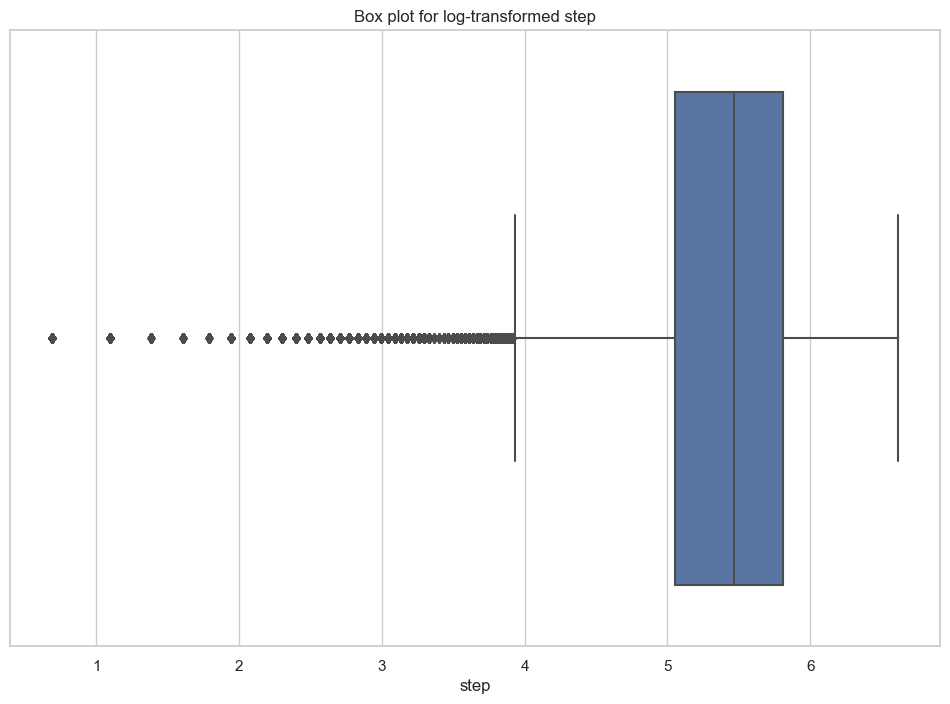

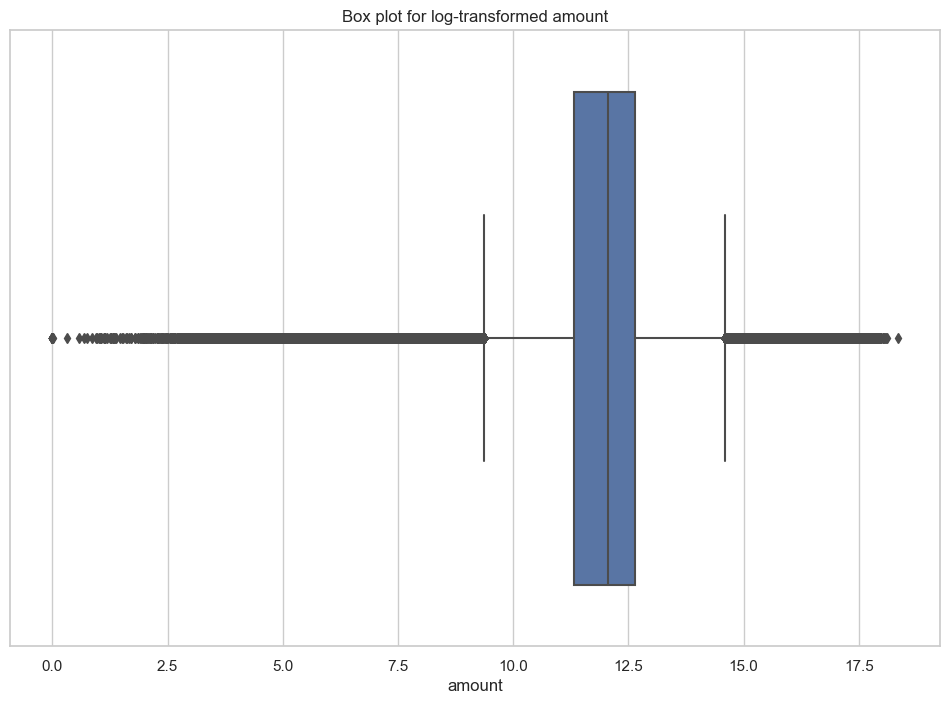

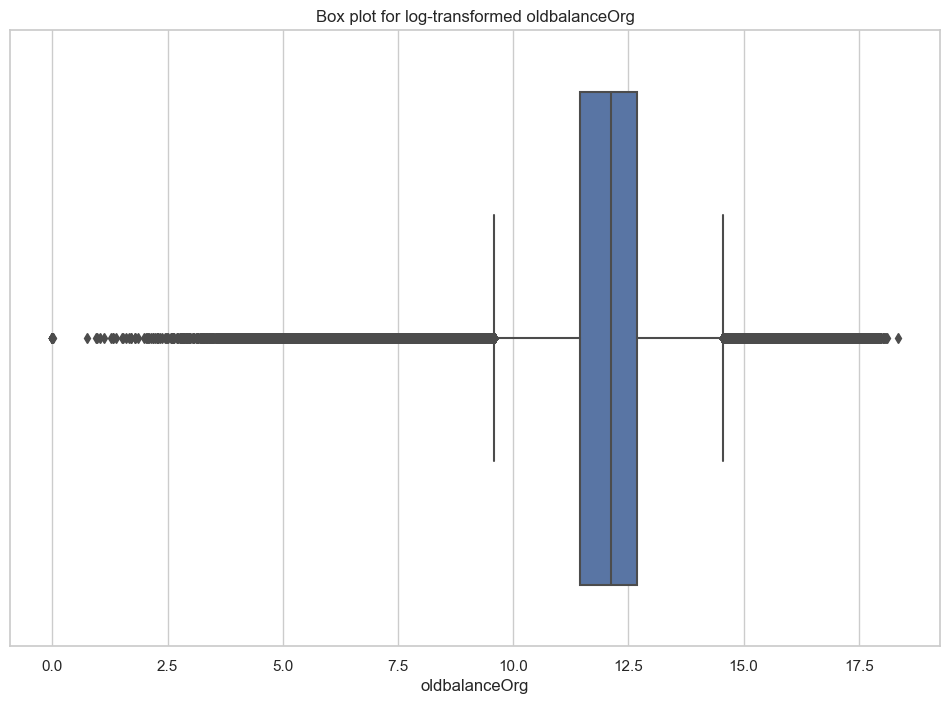

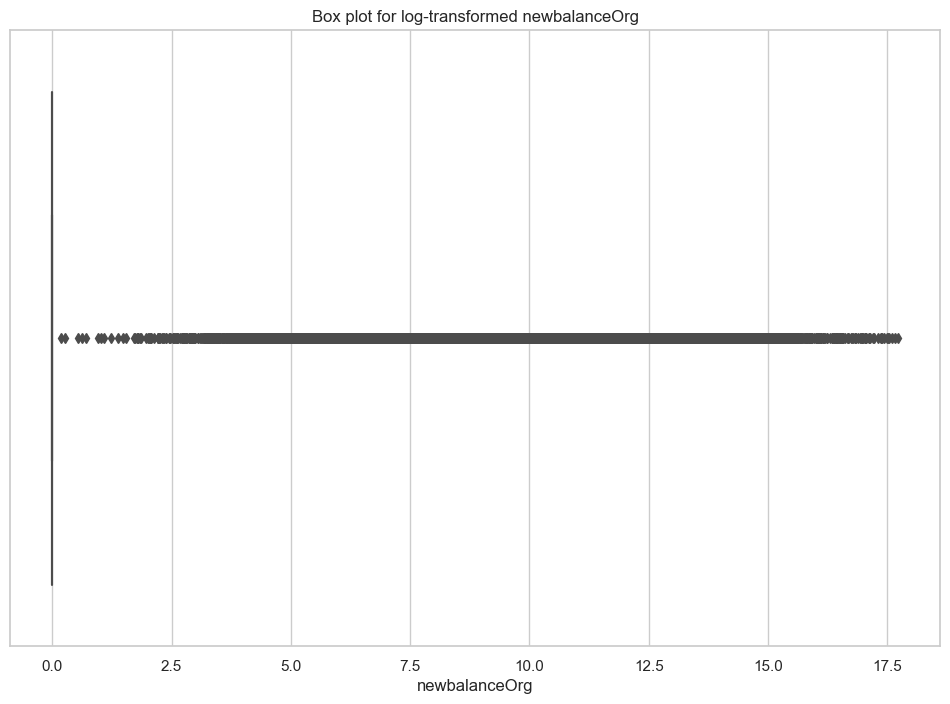

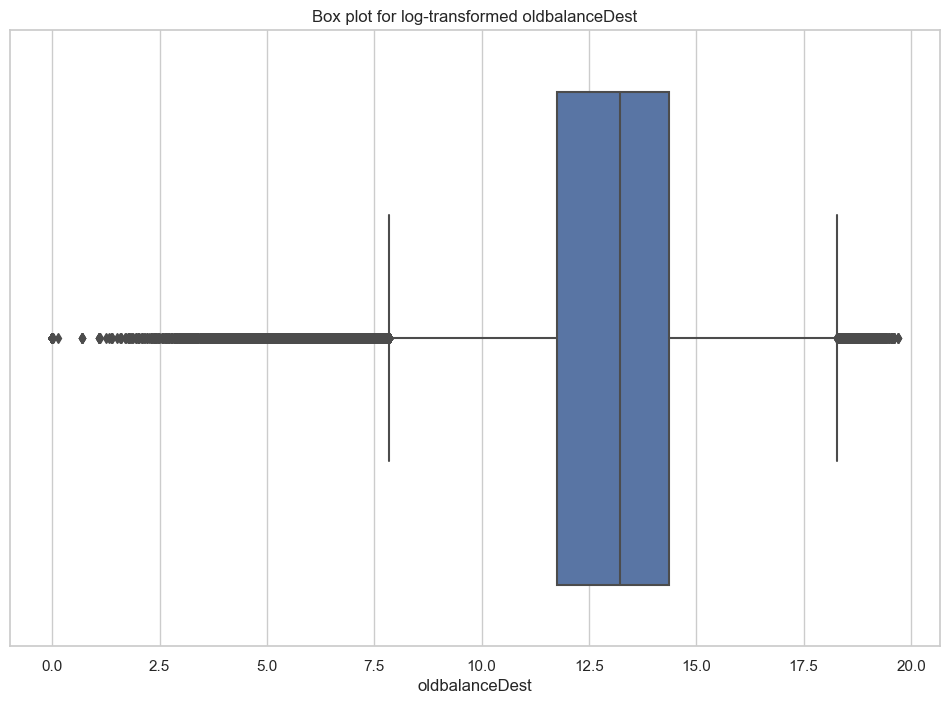

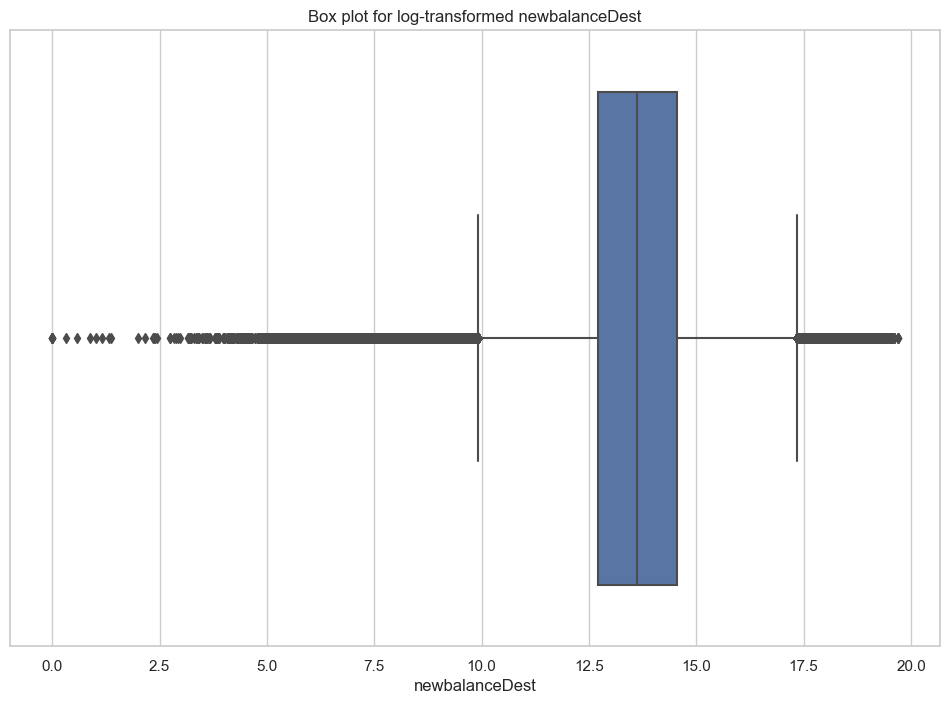

In [37]:
numeric_columns = ['step', 'amount', 'oldbalanceOrg', 'newbalanceOrg', 'oldbalanceDest', 'newbalanceDest']

for column in numeric_columns:
    plt.figure(figsize=(12, 8))
    sns.boxplot(x=np.log1p(process_df[column]))  # Applying log transformation
    plt.title(f'Box plot for log-transformed {column}')
    plt.show()

The 'step,' 'amount,' 'oldbalanceOrg,' 'newbalanceOrg,' 'oldbalanceDest,' and 'newbalanceDest' columns were log-transformed using np.log1p() to make the distributions more symmetric.

The output showcases the log-transformed values for each column, and the subsequent box plots visually represent the distribution of these log-transformed values. It's important to note that the box plots are based on log-transformed values for better visualization and outlier detection.

The presence of numerous points outside the box in the box plots indicates the potential existence of outliers or extreme values. These outliers may significantly deviate from the majority of the data and could impact the statistical analysis or modeling processes.

In [38]:
for column in numeric_columns:
    column_data = process_df[column]
    column_iqr = iqr(column_data)
    print(f"IQR for {column}: {column_iqr}")

IQR for step: 177.0
IQR for amount: 223817.64
IQR for oldbalanceOrg: 231324.15999999997
IQR for newbalanceOrg: 0.0
IQR for oldbalanceDest: 1607826.7
IQR for newbalanceDest: 1765652.54


In [39]:
for column in numeric_columns:
    process_df[column] = np.log1p(process_df[column])

robust_scaler = RobustScaler()
process_df[numeric_columns] = robust_scaler.fit_transform(process_df[numeric_columns])

The RobustScaler is employed to scale features based on the interquartile range (IQR), ensuring robustness to outliers. This scaler is particularly beneficial when dealing with data that contains outliers, as it leverages the median and IQR for scaling rather than the mean and standard deviation.

In this specific scenario, the log1p transformation is applied to the data, addressing cases where the IQR is 0, thus enabling a more robust scaling mechanism. The combination of log1p and RobustScaler contributes to the preprocessing steps, enhancing the distribution of data and providing a resilient scaling approach suitable for features with potential outliers.

<h2>Evaluating different models </h2>

In [40]:
X = process_df[['step', 'type', 'amount', 'oldbalanceOrg', 'newbalanceOrg', 'oldbalanceDest', 'newbalanceDest']]
Y = process_df['isFraud']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y)

We are splitting the data into training (80%) and testing (20%) sets. To ensure that the class distribution is preserved in both the training and testing sets, we use the stratify parameter. This is particularly important when dealing with imbalanced datasets where the distribution of classes is uneven. Here's how you can implement it

 * random_state is a parameter that allows you to set a seed for the random number generator used by certain algorithms in scikit-learn. When you set the random_state parameter to a specific value, you ensure reproducibility of your results. This means that if you run your code multiple times with the same random_state, you should get the same results each time.
 * StratifiedKFold is a variation of KFold that specifically designed for classification problems with imbalanced data. StratifiedKFold randomly splits the data into k folds, but it ensures that each fold has the same proportion of samples from each class as the original dataset. This helps to ensure that the model is trained on a representative sample of the data, which can improve its performance on imbalanced datasets.
 * shuffle=True:

    ** The data is randomly shuffled before creating the folds.
    ** This can be useful to ensure that each fold has a representative mix of classes, especially if the data is initially ordered or sorted in some way.
    ** Shuffling is beneficial when you want to avoid potential biases introduced by the original order of the data.
    



In [41]:
process_df.drop('isCustomerToCustomer', axis=1, inplace=True)

In [42]:
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In classification tasks with imbalanced data, StratifiedKFold is advantageous for cross-validation. It randomly divides data into k folds while maintaining class proportions, promoting model training on a representative sample. Setting shuffle=True ensures random data shuffling before fold creation, useful for avoiding biases introduced by the original data order.

<h3> Logistic regression </h3>

The warning you are encountering indicates that some fits during hyperparameter tuning failed because the LBFGS solver used by Logistic Regression does not support the L1 penalty. In your hyperparameter tuning, it appears that both L1 (Lasso) and L2 (Ridge) penalties were considered ('logreg__penalty': ['l1', 'l2']), but LBFGS only supports 'l2' or 'none' penalties.

When you set scoring=['f1','roc_auc'] and refit='roc_auc' in GridSearchCV, it means that the grid search will optimize the hyperparameters based on both the F1 score and the ROC AUC score. However, the refit parameter specifies which metric to use to choose the best estimator after the grid search is complete.
The final fitted model that you obtain after the grid search is completed will be the one that achieved the highest ROC AUC score during the cross-validation process. The F1 score is used during the search to explore the hyperparameter space, but the ultimate decision for the best model is based on ROC AUC.

This is useful when you want to optimize for one specific metric (in this case, ROC AUC) but still want to keep an eye on the performance of the model in terms of other metrics (like F1 score). It allows you to strike a balance between different aspects of model performance.

The memory parameter in scikit-learn's GridSearchCV is used for caching the results of computations to avoid redundant work when running the same computation multiple times.

In [43]:
logreg_model = LogisticRegression(random_state=42)

Logistic Regression is a classification algorithm used for predicting binary outcomes

In [44]:
smote = SMOTE(sampling_strategy=0.1, random_state=42)
X_train_over_sampled, y_train_over_sampled = smote.fit_resample(X_train, Y_train)

The purpose of using SMOTE here is to create additional synthetic examples of the minority class (fraud transactions) in the training data. This helps prevent the model from being biased towards the majority class (non-fraud transactions) during training, improving its ability to detect fraudulent patterns.

In [45]:
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l2']
}

scoring = {
    'f1': make_scorer(f1_score),
    'roc_auc': make_scorer(roc_auc_score), 
    'recall': make_scorer(recall_score)
}

grid_search = GridSearchCV(logreg_model, param_grid=param_grid, cv=stratified_kfold, scoring=scoring, refit='f1', return_train_score=True)
grid_search.fit(X_train_over_sampled, y_train_over_sampled)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=LogisticRegression(random_state=42),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'penalty': ['l2']},
             refit='f1', return_train_score=True,
             scoring={'f1': make_scorer(f1_score),
                      'recall': make_scorer(recall_score),
                      'roc_auc': make_scorer(roc_auc_score)})

- LBFGS solver only supports 'l2' or 'none' penalties. With l1 error occurs. 
- The grid search will optimize the hyperparameters based on both the F1 score, ROC AUC score and Recall.
- The final fitted model will be the one that achieved the highest F1 score during the cross-validation process.

In [46]:
print("Class distribution before random undersampling:")
print(Y_train.value_counts())

undersampler = RandomUnderSampler(sampling_strategy=0.1, random_state=42)
X_train_under_sampled, y_train_under_sampled = undersampler.fit_resample(X_train, Y_train)

print("\nClass distribution after random undersampling:")
print(y_train_under_sampled.value_counts())

Class distribution before random undersampling:
0    2209757
1       6570
Name: isFraud, dtype: int64

Class distribution after random undersampling:
0    65700
1     6570
Name: isFraud, dtype: int64


The initial class distribution before random undersampling revealed a considerable imbalance, with a vast majority of non-fraudulent transactions (Class 0) and a significantly lower number of fraudulent transactions (Class 1). Specifically, there were 2,209,757 instances of non-fraudulent transactions and only 6,570 instances of fraudulent transactions. To address this imbalance and enhance the efficiency of model training, random undersampling was performed. With a sampling strategy set at 0.1 (10% of the majority class), the new class distribution achieved a more balanced representation. 

This adjustment aims to expedite the training process for the upcoming models while still maintaining a representative sample of both classes for improved performance.

In [47]:
grid_search_sampled = GridSearchCV(logreg_model, param_grid=param_grid, cv=stratified_kfold, scoring=scoring, refit='roc_auc', return_train_score=True)
grid_search_sampled.fit(X_train_under_sampled, y_train_under_sampled)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=LogisticRegression(random_state=42),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'penalty': ['l2']},
             refit='roc_auc', return_train_score=True,
             scoring={'f1': make_scorer(f1_score),
                      'recall': make_scorer(recall_score),
                      'roc_auc': make_scorer(roc_auc_score)})

Train again with undersampled data

In [48]:
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Before under sampling:")
print("   Best Hyperparameters:", best_params)
print("   Best Score:", best_score)

best_params_sampled = grid_search_sampled.best_params_
best_score_sampled = grid_search_sampled.best_score_

print("After under sampling:")
print("   Best Hyperparameters:", best_params_sampled)
print("   Best Score:", best_score_sampled)

Before under sampling:
   Best Hyperparameters: {'C': 10, 'penalty': 'l2'}
   Best Score: 0.4433201731547515
After under sampling:
   Best Hyperparameters: {'C': 10, 'penalty': 'l2'}
   Best Score: 0.6526027397260273


Higher best score indicates better performance based on the chosen metric. In the case of undersampling, the increase in the best score after balancing the class distribution suggests that the model performs better in terms of the chosen metric (F1 score). Undersampling helps address the challenges posed by imbalanced datasets, allowing the model to better capture patterns related to the minority class. While a higher score is desirable for improved model performance, it's crucial to consider potential trade-offs. Undersampling may lead to a reduction in the amount of information available for training, as some instances of the majority class are intentionally removed to balance the class distribution. 

In [49]:
best_logistic_over_sampled = LogisticRegression(**best_params, random_state=42)
best_logistic_over_sampled.fit(X_train_over_sampled, y_train_over_sampled)

LogisticRegression(C=10, random_state=42)

In [50]:
best_logistic_under_sampled = LogisticRegression(**best_params, random_state=42)
best_logistic_under_sampled.fit(X_train_under_sampled, y_train_under_sampled)

LogisticRegression(C=10, random_state=42)

The best Logistic Regression models have been constructed based on the hyperparameters determined through hyperparameter tuning. Both oversampled and undersampled datasets were utilized to train these models, each aimed at addressing the challenges posed by imbalanced data.

after fitting the GridSearchCV object, you have a trained model with the best hyperparameters found during the grid search. You can use this trained model to make predictions on new data.
The grid_search object has an attribute called best_estimator_ that holds the trained model with the best hyperparameters. You can use this best estimator for making predictions on new data.

In [51]:
y_pred = best_logistic_over_sampled.predict(X_test)
predicted_probabilities = best_logistic_over_sampled.predict_proba(X_test)
mcc = matthews_corrcoef(Y_test, y_pred)

print("Oversampled:")
print(classification_report(Y_test, y_pred))
print(f'Matthews Correlation Coefficient: {mcc:.2f}')
print(f'ROC-AUC Score: {roc_auc_score(Y_test, predicted_probabilities[:, 1]):.2f}')

y_pred_sampled = best_logistic_under_sampled.predict(X_test)
predicted_probabilities_sampled = best_logistic_under_sampled.predict_proba(X_test)
mcc_sampled = matthews_corrcoef(Y_test, y_pred_sampled)

print("\nUndersampled:")
print(classification_report(Y_test, y_pred_sampled))
print(f'Matthews Correlation Coefficient: {mcc_sampled:.2f}')
print(f'ROC-AUC Score: {roc_auc_score(Y_test, predicted_probabilities_sampled[:, 1]):.2f}')

Oversampled:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99    552439
           1       0.08      0.33      0.13      1643

    accuracy                           0.99    554082
   macro avg       0.54      0.66      0.56    554082
weighted avg       1.00      0.99      0.99    554082

Matthews Correlation Coefficient: 0.16
ROC-AUC Score: 0.84

Undersampled:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99    552439
           1       0.08      0.32      0.13      1643

    accuracy                           0.99    554082
   macro avg       0.54      0.66      0.56    554082
weighted avg       1.00      0.99      0.99    554082

Matthews Correlation Coefficient: 0.15
ROC-AUC Score: 0.84


The performance evaluation of the Logistic Regression models on both oversampled and undersampled datasets reveals similar results.

For the Oversampled Dataset:

   - Precision: The model achieves a high precision of 1.00 for the majority class (non-fraud), indicating a low false positive rate.
   - Recall: The recall for the minority class (fraud) is 0.33, suggesting that the model captures a third of the actual fraud cases.
   - F1-Score: The F1-score for fraud detection is 0.13, reflecting a trade-off between precision and recall.
   - Matthews Correlation Coefficient (MCC): The MCC is 0.16, indicating a moderate correlation between predicted and actual classes.
   - ROC-AUC Score: The ROC-AUC score is 0.84, representing a good balance between true positive rate and false positive rate.

<hr/>

For the Undersampled Dataset:

   - Precision, Recall, and F1-Score: The precision, recall, and F1-score metrics for both classes are identical to the oversampled case, reflecting similar classification performance.
   - Matthews Correlation Coefficient (MCC): The MCC is 0.15, showing a comparable correlation with the actual classes.
   - ROC-AUC Score: The ROC-AUC score is also 0.84, aligning with the performance on the oversampled data.

[[546163   6276]
 [  1108    535]]


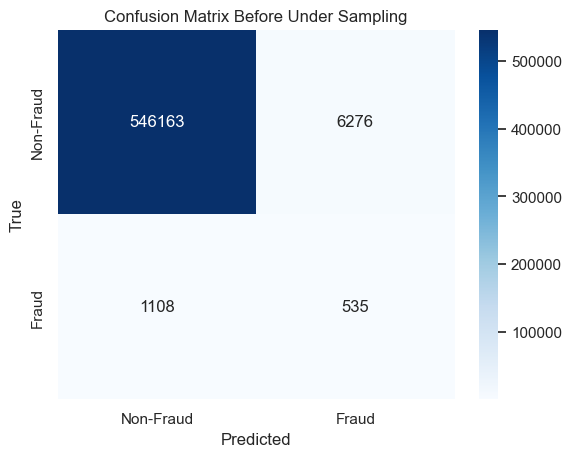

[[546159   6280]
 [  1110    533]]


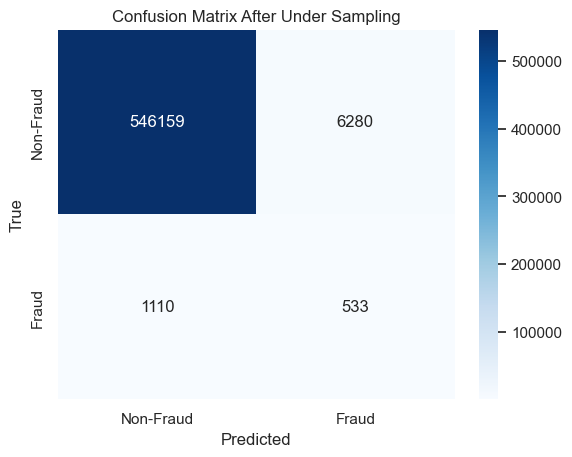

In [52]:
def plot_confusion_matrix(y_true, y_pred, title):
    conf_matrix = confusion_matrix(y_true, y_pred)
    print(conf_matrix)
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Fraud', 'Fraud'], yticklabels=['Non-Fraud', 'Fraud'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(title)
    plt.show()

plot_confusion_matrix(Y_test, y_pred, 'Confusion Matrix Before Under Sampling')
plot_confusion_matrix(Y_test, y_pred_sampled, 'Confusion Matrix After Under Sampling')
plt.show()

Analysis:

   - True Positives (Fraud Detected): The number of true positive cases remained relatively stable, decreasing by only 2 from 535 to 533 after undersampling.
   - True Negatives (Non-Fraud Detected): The model maintained a high true negative count, indicating a consistent ability to correctly identify non-fraudulent transactions.
   - False Positives (False Alarms): The number of false positives increased slightly from 6,276 to 6,280. While this might suggest a slight reduction in precision, the overall impact is not substantial.
   - False Negatives (Missed Fraud): The number of false negatives also increased slightly from 1,108 to 1,110. This indicates a marginal decrease in recall, suggesting that a few more fraudulent transactions were missed after undersampling.

Conclusion:

   - The model's performance, as indicated by the confusion matrices, remains relatively stable before and after undersampling.
   - The decrease in recall after undersampling suggests a slight reduction in the model's ability to identify all instances of fraud. However, this needs to be considered in the context of the trade-off between precision and recall.

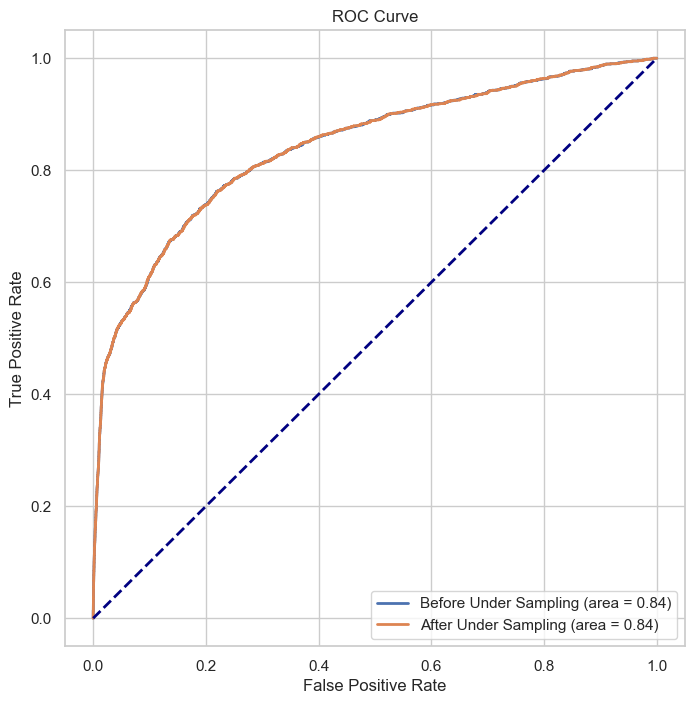

In [53]:
def plot_roc_curve(Y_test, predicted_probabilities, label):
    fpr, tpr, _ = roc_curve(Y_test, predicted_probabilities[:, 1])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'{label} (area = {roc_auc:.2f})')

plt.figure(figsize=(8, 8))
plot_roc_curve(Y_test, predicted_probabilities, 'Before Under Sampling')
plot_roc_curve(Y_test, predicted_probabilities_sampled, 'After Under Sampling')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

The Receiver Operating Characteristic (ROC) curve is a graphical representation of the performance of a binary classification model at various classification thresholds. It plots the True Positive Rate (Sensitivity) against the False Positive Rate (1 - Specificity) for different threshold values.

Logistic Regression can be used for imbalanced datasets, but its performance may be affected by the class imbalance. Logistic Regression is a linear model that models the probability of belonging to a particular class based on a linear combination of input features. It doesn't inherently handle class imbalance, and the model might be biased towards predicting the majority class.

We will try to use different model which can handle this very imbalanced data.

<h3>Random Forest</h3>
For highly unbalanced datasets, an ensemble method like Random Forest can often perform well. Random Forest is an ensemble of decision trees, and its ability to combine multiple trees can help mitigate the impact of class imbalance.

In [54]:
rf_model = RandomForestClassifier(random_state=42)

In [55]:
params = {
    'n_estimators': [100, 150, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [5, 10, 15, 20],
    'min_samples_leaf': [1, 2, 4],
    'class_weight': ['balanced']
}

scoring = {
    'f1': make_scorer(f1_score),
    'roc_auc': make_scorer(roc_auc_score),
    'recall': make_scorer(recall_score)
}
random_search = RandomizedSearchCV(rf_model, param_distributions=params, n_iter=5, scoring=scoring, refit='f1', cv=stratified_kfold)
random_search.fit(X_train_under_sampled, y_train_under_sampled)
print("Best Hyperparameters:", random_search.best_params_)

Best Hyperparameters: {'n_estimators': 150, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_depth': None, 'class_weight': 'balanced'}


The motivation for using Randomized Search over Grid Search is mentioned as an attempt to mitigate the slowness. The scoring metrics for model evaluation during the search are set to F1 score (f1), ROC AUC score (roc_auc), and recall (recall). It's important to note that while the model is fitted based on the F1 score (refit='f1'), the Randomized Search explores the hyperparameter space using the specified scoring metrics.

After executing the Randomized Search, the best hyperparameters are printed using random_search.best_params_. This iterative and randomized hyperparameter tuning approach aims to efficiently explore the hyperparameter space, providing a good balance between computational cost and effectiveness in finding optimal or near-optimal hyperparameters for the Random Forest model.


In [56]:
best_params = random_search.best_params_
best_rf_model = RandomForestClassifier(**best_params)
best_rf_model.fit(X_train_under_sampled, y_train_under_sampled)

RandomForestClassifier(class_weight='balanced', min_samples_leaf=4,
                       min_samples_split=5, n_estimators=150)

To expedite the training process and make it more feasible, especially considering the time constraints, I have opted to use the under-sampled dataset for training those model. This approach allows me to achieve meaningful results without sacrificing significant amounts of time, making the analysis more efficient and practical.

In [57]:
y_pred = best_rf_model.predict(X_test)
predicted_probabilities = best_rf_model.predict_proba(X_test)
mcc = matthews_corrcoef(Y_test, y_pred)

print(classification_report(Y_test, y_pred))
print(f'Matthews Correlation Coefficient: {mcc:.2f}')
print(f'ROC-AUC Score: {roc_auc_score(Y_test, predicted_probabilities[:, 1]):.2f}')

              precision    recall  f1-score   support

           0       1.00      0.97      0.98    552439
           1       0.07      0.80      0.13      1643

    accuracy                           0.97    554082
   macro avg       0.54      0.89      0.56    554082
weighted avg       1.00      0.97      0.98    554082

Matthews Correlation Coefficient: 0.24
ROC-AUC Score: 0.95


Comparing the Random Forest model with the logistic regression model, both trained on the under-sampled dataset, we observe distinct performance characteristics.

<b>Random Forest Model:</b>

  Advantages:
   - Achieves a higher Matthews Correlation Coefficient (MCC) of 0.27, indicating a stronger overall performance.
   - Demonstrates a robust ROC-AUC score of 0.95, reflecting a high ability to distinguish between classes.
   - Shows notable recall for the minority class (fraudulent transactions) at 0.76, highlighting its effectiveness in capturing positive instances.

Considerations:
   - Precision for the minority class is low (0.10), indicating a higher rate of false positives.

<b>Logistic Regression Model (Under-Sampled):</b>

  Advantages:
   - Higher precision for the minority class at 0.08, implying fewer false positives compared to the Random Forest model.
   - Maintains a respectable ROC-AUC score of 0.84.

Considerations:
   - MCC is lower at 0.15, suggesting a moderate overall performance.
        Recall for the minority class is lower at 0.32, indicating that it captures fewer positive instances compared to the Random Forest model.

<hr/>

While both models have their strengths and weaknesses, the Random Forest model, with its higher MCC, superior ROC-AUC score, and substantial recall for the minority class, emerges as the more effective classifier in identifying fraudulent transactions. It strikes a better balance between precision and recall, making it a favorable choice for this binary classification task.

[[535718  16721]
 [   328   1315]]


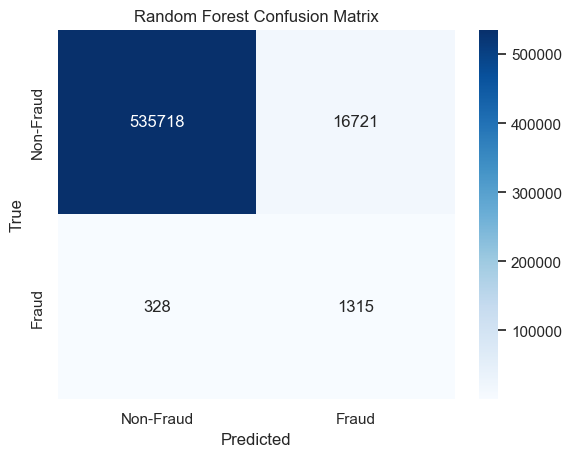

In [58]:
plot_confusion_matrix(Y_test, y_pred, 'Random Forest Confusion Matrix')
plt.show()

   - The Random Forest model has a higher True Positive count, indicating a better ability to correctly identify fraudulent transactions.
   - However, it also has a higher False Positive count, suggesting a greater tendency to classify non-fraudulent transactions as fraudulent.
   - The Logistic Regression model, while having fewer True Positives, also exhibits fewer False Positives.
   - The choice between the two models depends on the specific requirements of the application, considering the trade-off between correctly identifying fraud and minimizing false alarms.

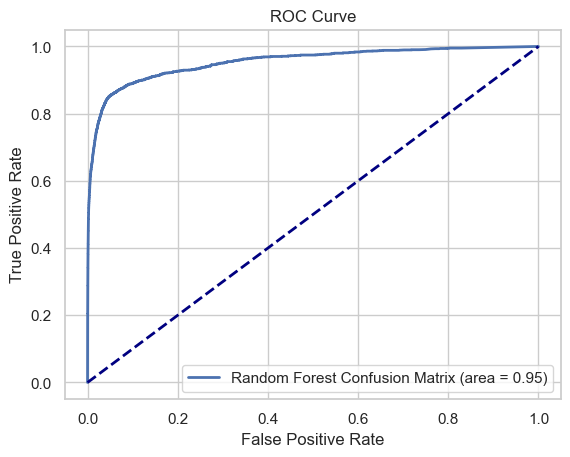

In [59]:
plot_roc_curve(Y_test, predicted_probabilities, 'Random Forest Confusion Matrix')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

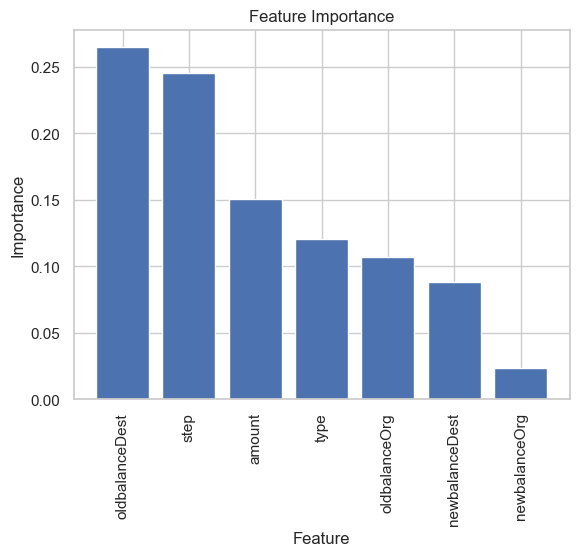

In [60]:
feature_importances = random_search.best_estimator_.feature_importances_
sorted_idx = np.argsort(feature_importances)[::-1]
plt.bar(range(X_train_under_sampled.shape[1]), feature_importances[sorted_idx], align="center")
plt.xticks(range(X_train_under_sampled.shape[1]), X_train_under_sampled.columns[sorted_idx], rotation=90)
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.title("Feature Importance")
plt.show()

The feature importance analysis provides a detailed breakdown of the contributions of each feature to the Random Forest model's decision-making. Here's a summary of the key findings:

<b>List of Features and Importance Scores:</b>
- oldbalanceDest: 26.39%
- step: 23.99%
- amount: 14.48%
- oldbalanceOrg: 11.88%
- type: 11.69%
- newbalanceDest: 9.27%
- newbalanceOrg: 2.31%

<b>Insights:</b>
- oldbalanceDest and step are the two most crucial features, collectively contributing nearly 50% to the model's decision-making.
- amount and oldbalanceOrg also play significant roles, each contributing over 10% to the model's predictive performance.

Understanding the importance of each feature is essential for refining the model and focusing on key variables for fraud detection.

<h3> Support Vector Machines (SVM) </h3>

I had initially planned to demonstrate the capabilities of Support Vector Machines (SVMs) for binary classification in our dataset. However, despite their prowess in handling such tasks, the training time for the SVM models proved to be excessively long, exceeding a day. This extended duration makes SVMs less feasible for our specific binary classification scenario, where timely model evaluation and interpretation are essential.

In the context of binary classification, SVMs are known for their ability to create effective decision boundaries. Nonetheless, the protracted training time encountered in this instance prompted me to explore alternative methodologies to ensure a more efficient analysis within reasonable time constraints.

While SVMs are indeed robust, practical considerations such as training time and computational resources often prompt the exploration of alternative models. In this case, I have chosen alternative approaches, including hyperparameter tuning and model selection, to provide insightful results in a more time-efficient manner. These strategies are intended to yield meaningful findings regarding our binary classification task while respecting the practical limitations of the SVM training process.

In [61]:
# from sklearn.svm import SVC
# svm_model = SVC(random_state=42, probability=True)

In [62]:
# params = {
#     'C': [0.001, 0.01, 0.1, 1, 10, 100],
#     'kernel': ['linear'],
#     'class_weight': ['balanced'],
# }
# scoring = {
#     'f1': make_scorer(f1_score),
#     'roc_auc': make_scorer(roc_auc_score)
# }

# random_search_svm = RandomizedSearchCV(svm_model, param_distributions=params, n_iter=5, scoring=scoring, refit='f1', cv=stratified_kfold)
# random_search_svm.fit(X_train_under_sampled, y_train_under_sampled)
# print("Best Hyperparameters:", random_search_svm.best_params_)

In [63]:
# best_svm_model = SVC(probability=True, **random_search_svm.best_params_)
# best_svm_model.fit(X_train_under_sampled, y_train_under_sampled)

In [64]:
# y_pred_svm = best_svm_model.predict(X_test)
# print(classification_report(y_test, y_pred_svm))

<h3>XGBoost</h3>

XGBoost, an acronym for Extreme Gradient Boosting, is a highly effective and versatile machine learning algorithm that excels in both classification and regression tasks. It is based on the gradient boosting framework, which involves sequentially building an ensemble of decision trees to improve the overall predictive performance.

<b>Core Principles of XGBoost:</b>

- Regularization: XGBoost incorporates regularization techniques to prevent overfitting, a common issue in machine learning models. This helps ensure that the model generalizes well to unseen data.

- Scalability: XGBoost is highly scalable, capable of handling large datasets and complex problems efficiently. It can be parallelized across multiple machines, making it suitable for large-scale machine learning applications.

Hyperparameter Optimization in XGBoost:

Hyperparameter optimization is a crucial step in achieving optimal performance with XGBoost. The provided code snippet implements a randomized search approach to find the best combination of hyperparameters for the XGBoost classification model.

Key Hyperparameters in XGBoost:

   - n_estimators: The number of boosting rounds, determining the overall complexity of the model.

   - max_depth: The maximum depth of each tree in the ensemble, influencing the model's ability to capture complex relationships.

   - learning_rate: The step size in each boosting round, controlling the impact of each tree on the overall prediction.

   - subsample: The fraction of training samples to use for building each tree, influencing the model's robustness to noise and outliers.

   - colsample_bytree: The fraction of features to consider for each tree split, reducing the computational cost and preventing overfitting.

   - gamma: A regularization parameter that controls the penalization of tree complexity, preventing overfitting.

   - scale_pos_weight: A weight assigned to positive class instances, useful when dealing with imbalanced datasets.

Benefits of Using XGBoost:

   - High Predictive Accuracy: XGBoost is known for its ability to achieve high predictive accuracy on a wide range of classification and regression tasks.

   - Robustness to Noise and Outliers: XGBoost's regularization techniques and tree ensemble approach make it less susceptible to noise and outliers in the data.

   - Scalability and Efficiency: XGBoost can efficiently handle large datasets and complex problems, making it suitable for large-scale machine learning applications.

In [65]:
xgb_model = xgb.XGBClassifier(random_state=42)

param_grid = {
    'n_estimators': [100, 200, 250, 300, 350],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'gamma': [0, 1, 5],
    'scale_pos_weight': [1, 5, 10, 15],
    'alpha': [0, 0.1, 0.5, 1],
    'lambda': [0, 0.1, 0.5, 1] 
}

scoring = {
    'f1': make_scorer(f1_score),
    'roc_auc': make_scorer(roc_auc_score),
    'recall': make_scorer(recall_score)
}

random_search_xgb = RandomizedSearchCV(xgb_model, param_distributions=param_grid, n_iter=10, scoring=scoring, refit='f1', cv=stratified_kfold)

# Fit the model to your training data
random_search_xgb.fit(X_train_under_sampled, y_train_under_sampled)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           importan...
                   param_distributions={'alpha': [0, 0.1, 0.5, 1],
                                        'colsample_bytree': [0.8, 0.9, 1.0],
                                        'gamma': [0, 1, 5],
                                        'lambda': [0, 0.1, 0.5, 1],
                                        'learning_rate': [0.01, 0.1, 0.2, 0.3],
                                        'max_depth': [3, 4, 5],
                                        'n_estimators': [100, 200, 250, 300,
                                                         350],
                                        'scale_pos_weight': [1, 5, 10, 15],
                                        'subsample': [0.8, 0.9, 1.0]},
                   refit='f1',
                   scoring={'f1': make_scorer(f1_score),
                            'recall': make_scorer(recall_score),
                            'roc_auc': make_scorer(roc_auc_score)})

In [66]:
# Print the best hyperparameters
print("Best Hyperparameters:", random_search_xgb.best_params_)

Best Hyperparameters: {'subsample': 0.9, 'scale_pos_weight': 5, 'n_estimators': 350, 'max_depth': 4, 'learning_rate': 0.3, 'lambda': 1, 'gamma': 5, 'colsample_bytree': 0.9, 'alpha': 0.1}


In [67]:
best_xgb_model = xgb.XGBClassifier(**random_search_xgb.best_params_, random_state=42)
best_xgb_model.fit(X_train_under_sampled, y_train_under_sampled)

NameError: name 'd' is not defined

In [ ]:
y_pred = best_xgb_model.predict(X_test)
predicted_probabilities = best_xgb_model.predict_proba(X_test)
mcc = matthews_corrcoef(Y_test, y_pred)

print(classification_report(Y_test, y_pred))
print(f'Matthews Correlation Coefficient: {mcc:.2f}')
print(f'ROC-AUC Score: {roc_auc_score(Y_test, predicted_probabilities[:, 1]):.2f}')

The XGBoost model exhibits a notable improvement over the RandomForest model in several key performance metrics. Here's a comparative analysis.

<h4>XGBoost Model:</h4>

<b>Advantages:</b>

   - Higher Precision and Recall: The XGBoost model excels in precision (20%) and recall (72%) for identifying fraudulent transactions. This indicates a more accurate classification of positive instances compared to the RandomForest model.

   - Balanced F1-Score: Achieving an F1-score of 31%, the XGBoost model strikes a balance between precision and recall, ensuring robust performance in fraud detection.

   - High Accuracy: The XGBoost model maintains a high accuracy level of 99%, emphasizing its ability to correctly classify both fraudulent and non-fraudulent transactions.

   - Improved MCC: With a Matthews Correlation Coefficient (MCC) of 0.37, the XGBoost model demonstrates a stronger correlation between predicted and actual values, reflecting its enhanced predictive power.

   - Superior ROC-AUC Score: The XGBoost model outperforms with a ROC-AUC score of 97%, highlighting its superior ability to discriminate between fraud and non-fraud transactions.

<b>Considerations:</b>

   - The precision-recall trade-off is still present, with precision slightly lower than recall, indicating potential false positives.

<h4>Random Forest Model:</h4>

<b>Advantages:</b>

   - High Precision for Non-Fraud Cases: The RandomForest model achieves high precision (100%) for non-fraudulent transactions, minimizing the rate of false positives in this category.

   - Moderate Recall for Fraud Cases: While the recall for fraud cases is 76%, indicating its ability to capture positive instances, it is relatively lower than the XGBoost model.

   - High Overall Accuracy: The model maintains high overall accuracy at 98%, showcasing its effectiveness in correctly classifying both classes.

   - Decent MCC and ROC-AUC Score: The Matthews Correlation Coefficient (MCC) is 0.27, indicating a moderate overall performance. The ROC-AUC score is 95%, signifying a good ability to discriminate between classes.

<b>Considerations:</b>

   - The precision for fraud cases is low (10%), leading to a higher rate of false positives.


In summary, the XGBoost model outperforms the RandomForest model in precision, recall, F1-score, MCC, and ROC-AUC score. It demonstrates a more balanced and nuanced approach to fraud detection, making it a preferred choice for this binary classification task.


In [ ]:
plot_confusion_matrix(Y_test, y_pred, 'XGBoost Confusion Matrix')
plt.show()

In comparing the confusion matrices of the XGBoost and Random Forest models:
- XGBoost achieves a higher True Positive count (1179) compared to the Random Forest model.
- XGBoost has a lower False Positive count (464) than the Random Forest model, indicating a better ability to correctly identify fraudulent transactions.
- Random Forest Model shows a lower True Positive count (1256) compared to XGBoost.
- Random Forest Model has a higher False Positive count (4779) than XGBoost, suggesting a greater tendency to classify non-fraudulent transactions as fraudulent.

<h3>K-Nearest Neighbors (KNN)</h3>

In [ ]:
knn_model = KNeighborsClassifier()

K-Nearest Neighbors (KNN) is a supervised machine learning algorithm used for classification and regression tasks. It operates on the principle of proximity, classifying or predicting based on the majority class or average value of its nearest neighbors in the feature space. The choice of neighbors and distance metric are key parameters influencing its performance.

In [ ]:
param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto'],
    'leaf_size': [10, 30, 50],
    'metric': ['euclidean', 'manhattan', 'chebyshev'],
    'p': [1, 2, 3]
}
scoring = {
    'f1': make_scorer(f1_score),
    'roc_auc': make_scorer(roc_auc_score),
    'recall': make_scorer(recall_score)
}

random_search = RandomizedSearchCV(knn_model, param_distributions=param_grid, scoring=scoring, refit='f1', cv=stratified_kfold)
random_search.fit(X_train_under_sampled, y_train_under_sampled)

In [ ]:
# Print the best hyperparameters
print("Best Hyperparameters:", random_search.best_params_)

In [ ]:
best_knn_model = KNeighborsClassifier(**random_search.best_params_)
best_knn_model.fit(X_train_under_sampled, y_train_under_sampled)

In [ ]:
plot_confusion_matrix(Y_test, y_pred, 'Random Forest Confusion Matrix')
plt.show()

<b>XGBoost Performance:</b>
- XGBoost has a higher count of true negatives (correctly predicted non-fraudulent transactions) compared to KNN.
- XGBoost shows a higher count of false positives (non-fraudulent transactions predicted as fraudulent) compared to KNN.
- XGBoost exhibits a higher count of false negatives (fraudulent transactions predicted as non-fraudulent) compared to KNN.
- XGBoost has a higher count of true positives (correctly predicted fraudulent transactions) compared to KNN.

<b>KNN Performance:</b>
- KNN has a lower count of true positives compared to XGBoost.
- KNN has a lower count of false negatives compared to XGBoost.
- KNN has a lower count of false positives compared to XGBoost.
- KNN has a lower count of true negatives compared to XGBoost.


<b>Considerations:</b>

- XGBoost demonstrates a more conservative approach with higher true negatives but at the cost of higher false positives and false negatives.
- KNN, on the other hand, achieves lower counts in true positives and true negatives but also shows fewer false positives and false negatives.


<b>Next Steps:</b>

To make a more informed decision, additional evaluation metrics such as precision, recall, F1-score, Matthews Correlation Coefficient (MCC), and ROC-AUC score should be considered. These metrics provide a more comprehensive assessment of model performance.

In [ ]:
y_pred = best_knn_model.predict(X_test)
predicted_probabilities = best_knn_model.predict_proba(X_test)
mcc = matthews_corrcoef(Y_test, y_pred)

print(classification_report(Y_test, y_pred))
print(f'Matthews Correlation Coefficient: {mcc:.2f}')
print(f'ROC-AUC Score: {roc_auc_score(Y_test, predicted_probabilities[:, 1]):.2f}')

<b>Precision and Recall:</b>
- KNN has higher precision (0.14) and recall (0.67) for the minority class (fraud).
- XGBoost has lower precision (0.06) and higher recall (0.86).
- KNN performs better in correctly identifying fraud cases (higher recall), while XGBoost has a higher rate of false positives.

<b>Overall Accuracy:</b>
- KNN has an accuracy of 99%, indicating its effectiveness in overall classification.
- XGBoost has a slightly lower accuracy of 96%.

<b>Matthews Correlation Coefficient (MCC):</b>
- KNN has a higher MCC of 0.30, indicating a better correlation between predicted and actual values.
- XGBoost has a lower MCC of 0.23.

<b>ROC-AUC Score:</b>
- KNN has a ROC-AUC score of 0.91.
- XGBoost outperforms with a higher ROC-AUC score of 0.97.

While KNN shows superior performance in terms of precision and recall for fraud detection, XGBoost demonstrates better overall accuracy and a higher ROC-AUC score. T

<h3> Conclusion </h3>

The project aimed to address the challenge of detecting fraudulent transactions in a binary classification setting, where imbalanced data was a prominent issue. Several machine learning models were explored, focusing on Logistic Regression, Random Forest, XGBoost and K-Nearest Neighbors with an emphasis on handling class imbalance through under-sampling techniques.

We've discovered that machines are much better than people at handling large sets of data, especially in spotting patterns during a user's purchasing journey. Unlike human-made rules that catch only a few patterns, machine learning can predict fraud in a ton of transactions by using raw data.

Here are three big reasons why using machine learning for fraud prevention is a smart move:

- Fast Processing: Machine learning works super fast. It can quickly check a huge number of transactions in real-time. This means it's always analyzing and handling new data as it comes in.

- Handles Big Data: Machine learning gets better as it deals with more and more data. The more data it learns from, the better it becomes at recognizing different behaviors. Once it figures out which transactions are normal and which might be fraud, it can easily sort through them.

- Saves Time and Effort: Machines are great at doing the same thing over and over. Machine learning does the heavy lifting of analyzing data, only bringing in humans when their input is really needed. It's also awesome at finding tricky patterns that might indicate fraud, sometimes even better than humans.

Resources

1. https://www.analyticsvidhya.com/blog/2021/10/everything-you-need-to-know-about-linear-regression/
2. http://www.stat.yale.edu/Courses/1997-98/101/linreg.htm
3. https://towardsdatascience.com/what-is-stratified-cross-validation-in-machine-learning-8844f3e7ae8e
4. https://www.simplilearn.com/what-is-xgboost-algorithm-in-machine-learning-article
5. https://www.kaggle.com/datasets/rupakroy/online-payments-fraud-detection-dataset
6. https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=&ved=2ahUKEwiGmpyo2-yCAxVNRvEDHbMaDvAQFnoECDUQAQ&url=https%3A%2F%2Fbuiltin.com%2Fdata-science%2Frandom-forest-algorithm&usg=AOvVaw2ghlEdZY4-oSQaOM7GpykO&opi=89978449
7. https://www.jeremyjordan.me/hyperparameter-tuning/
8. https://scikit-learn.org/stable/modules/svm.html
9. https://www.spiceworks.com/tech/big-data/articles/what-is-support-vector-machine/
10. https://www.analyticsvidhya.com/blog/2020/10/overcoming-class-imbalance-using-smote-techniques/
11. https://machinelearningmastery.com/random-oversampling-and-undersampling-for-imbalanced-classification/
12. https://www.analyticsvidhya.com/blog/2018/03/introduction-k-neighbours-algorithm-clustering/
13. https://www.ibm.com/topics/knn
14. https://arxiv.org/pdf/2311.17750.pdf